BTC/LTC.csv have: <br>
Date,Open,High,Low,Close,Adj Close,Volume

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Example data loading (replace with actual data source)
btc_data = pd.read_csv('BTC5m.csv')
eth_data = pd.read_csv('ETH5m.csv')

# Merge DataFrames on the 'Date' column, keeping only the 'Date' and 'close' columns
merged_data = pd.merge(btc_data[['Date', 'close']], eth_data[['Date', 'close']], on='Date', how='inner')

# Rename columns for clarity
merged_data.columns = ['Date', 'BTC_close', 'ETH_close']
merged_data_short2 = merged_data[merged_data['Date'] >= '2024-05-01']
merged_data.set_index('Date', inplace=True)
merged_data

,BTC_close,ETH_close
Date,,
2018-01-01 00:00:00,13600.00,728.93
2018-01-01 00:05:00,13554.58,727.25
2018-01-01 00:10:00,13556.15,727.31
2018-01-01 00:15:00,13430.52,724.99
2018-01-01 00:20:00,13439.94,723.03
...,...,...
2024-05-18 23:35:00,67005.06,3123.40
2024-05-18 23:40:00,66996.61,3123.76
2024-05-18 23:45:00,66975.64,3123.06


Correlation between present day's ETH closing price and next day's BTC closing price:0.9276591494450462


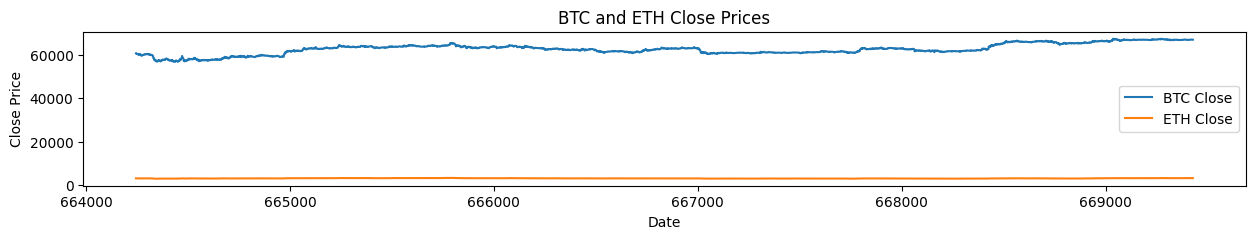

Correlation between present day's ETH closing price and next day's BTC closing price:0.9276591494450462


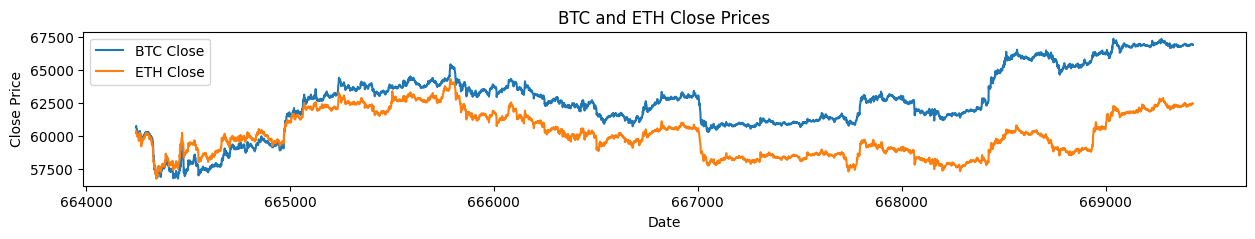

In [2]:
merged_data_short = merged_data


correlation = np.corrcoef(merged_data_short['ETH_close'], merged_data_short[f'BTC_close'])[0, 1]
# Print correlation and the first few rows of the dataset for verification
print(f"Correlation between present day's ETH closing price and next day's BTC closing price:{correlation}")
plt.figure(figsize=(15, 2))
plt.plot(merged_data_short2.index, merged_data_short2['BTC_close'], label='BTC Close')
plt.plot(merged_data_short2.index, merged_data_short2['ETH_close'], label='ETH Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC and ETH Close Prices')
plt.legend()
plt.show()
correlation = np.corrcoef(merged_data['ETH_close'], merged_data[f'BTC_close'])[0, 1]
# Print correlation and the first few rows of the dataset for verification
print(f"Correlation between present day's ETH closing price and next day's BTC closing price:{correlation}")
plt.figure(figsize=(15, 2))
plt.plot(merged_data_short2.index, merged_data_short2['BTC_close'], label='BTC Close')
plt.plot(merged_data_short2.index, merged_data_short2['ETH_close']*20, label='ETH Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC and ETH Close Prices')
plt.legend()
plt.show()

Prepare Training & Test Sets and Standardize the Data

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.cuda.empty_cache()

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Assuming 'merged_data_short' is a DataFrame with 'BTC_close' and 'ETH_close' columns
data = merged_data_short[['BTC_close', 'ETH_close']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences of the last 6 hours for every 5 minutes 5*72 = 360 minutes = 6 hours
sequence_length = 72
hidden_size = 64  # Adjusted hidden size
num_layers = 2    # Increased number of layers
epochs = 100000      # Increased number of epochs
batch_size = 512  # Adjusted batch size
early_stop_epoch = 10000

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, 0]  # Using only BTC Price as feature
        y = data[i+seq_length, 1]    # ETH Price as target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the neural network
class ETHPricePredictor(nn.Module):
    def __init__(self):
        super(ETHPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initialize hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initialize cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]  # Get the last time step output
        out = self.fc(out)
        return out

model = ETHPricePredictor().to(device)

# Load the model state if it exists
try:
    model.load_state_dict(torch.load('model2.pkl'))
    print("Model loaded successfully")
except FileNotFoundError:
    print("Model file not found, starting training from scratch")

# Define loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
min_loss = float('inf')
epoch_count = 0

# Define your data loader
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Train the model
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    
    # Update learning rate based on validation loss
    scheduler.step(avg_epoch_loss)
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.20f}')
        if avg_epoch_loss < min_loss:
            min_loss = avg_epoch_loss
            torch.save(model.state_dict(), 'model2.pkl')
            epoch_count = 0
            print(f"Model saved with loss {min_loss:.20f}")
        else:
            epoch_count += 1
            print(f"No improvement, count: {epoch_count}")
            
    if epoch_count > early_stop_epoch:
        print("Early stopping")
        break

# Evaluate the model in batches to avoid OOM
model.eval()
predictions = []
with torch.no_grad():
    for i in range(0, X_test.size(0), batch_size):
        X_batch = X_test[i:i+batch_size]
        output = model(X_batch)
        predictions.append(output.cpu().numpy())
        
predictions = np.concatenate(predictions).squeeze()
test_loss = criterion(torch.tensor(predictions).to(device), y_test)
print(f'Test Loss: {test_loss.item():.8f}')

# Convert predictions back to original scale
predicted_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predictions.shape[0], 1)), predictions.reshape(-1, 1)), axis=1)
)[:, 1]
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], 1)), y_test.cpu().numpy().reshape(-1, 1)), axis=1)
)[:, 1]

# Print sample results
for i in range(10):
    print(f'Predicted: {predicted_prices[i]:.2f}, Actual: {actual_prices[i]:.2f}')
#Model saved with loss 0.0033346157
#Model saved with loss 0.0033296287

cuda
Model loaded successfully
Epoch [1/100000], Loss: 0.00333151796518381610
Model saved with loss 0.00333151796518381610
Epoch [2/100000], Loss: 0.00333019211731608918
Model saved with loss 0.00333019211731608918
Epoch [3/100000], Loss: 0.00332934837846217196
Model saved with loss 0.00332934837846217196
Epoch [4/100000], Loss: 0.00333238213815428971
No improvement, count: 1
Epoch [5/100000], Loss: 0.00333167780575789434
No improvement, count: 2
Epoch [6/100000], Loss: 0.00333114539853601689
No improvement, count: 3
Epoch [7/100000], Loss: 0.00332972173597734884
No improvement, count: 4
Epoch [8/100000], Loss: 0.00332975822472392820
No improvement, count: 5
Epoch [9/100000], Loss: 0.00333129986007671148
No improvement, count: 6
Epoch 00010: reducing learning rate of group 0 to 1.0000e-08.
Epoch [10/100000], Loss: 0.00332996303333151162
No improvement, count: 7
Epoch [11/100000], Loss: 0.00333111707377559130
No improvement, count: 8
Epoch [12/100000], Loss: 0.00332847704294442171
Model

In [7]:
#0.0033296786
#0.0033296287


1000

In [8]:

# Print sample results
for i in range(10):
    print(f'Predicted: {predicted_prices[i]:.40f}, Actual: {actual_prices[i]:.10f}')



Predicted: 1511.2110735395551728288410231471061706542969, Actual: 1643.3999547267
Predicted: 1511.0616415774825327389407902956008911132812, Actual: 1644.9300297549
Predicted: 1510.9308708041908175800926983356475830078125, Actual: 1639.1799619293
Predicted: 1510.7250279203058198618236929178237915039062, Actual: 1632.3999674252
Predicted: 1510.4129159766437169309938326478004455566406, Actual: 1620.6499712768
Predicted: 1509.8639066517355331598082557320594787597656, Actual: 1617.0600428915
Predicted: 1508.9455197504164516431046649813652038574219, Actual: 1620.0700499064
Predicted: 1507.8588972464206108270445838570594787597656, Actual: 1624.2699569967
Predicted: 1506.7893689611555601004511117935180664062500, Actual: 1623.7099788815
Predicted: 1505.7410659974816553585696965456008911132812, Actual: 1616.9799849671
Predicted: 1504.6699707421662424167152494192123413085938, Actual: 1615.0000470826
Predicted: 1503.5840604972840992559213191270828247070312, Actual: 1614.9000459030
Predicted: 1502.

0.924811183502334


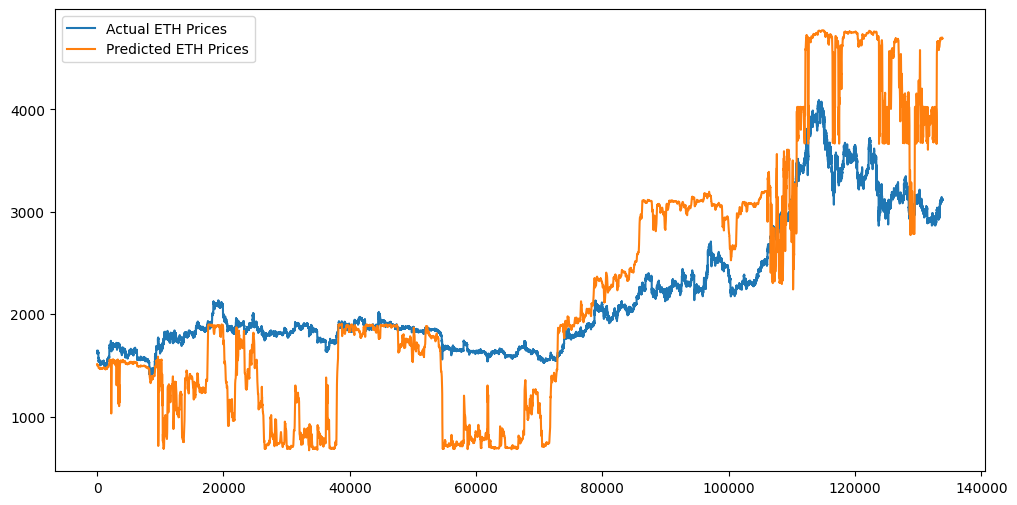

In [9]:
correlation = np.corrcoef(predicted_prices, actual_prices)[0, 1]
print(correlation)
# Plot predictions vs actual prices
plt.figure(figsize=(12, 6))
x1 = np.linspace(0, 1, 133857)
x2 = np.linspace(0, 1, 133857)
plt.plot(actual_prices, label='Actual ETH Prices')
plt.plot(predicted_prices, label='Predicted ETH Prices')
plt.legend()
plt.show()


In [10]:
0.9235370600614433

0.9235370600614433

In [ ]:
rms = 0
for i in range(len(predicted_prices)):
    rms += ((predicted_prices[i]-actual_prices[i])*(predicted_prices[i]-actual_prices[i]))
rms = rms/len(predicted_prices)
print('#',hidden_size,',',num_layers,',',rms)
#layer , hidden layer size,rms
#2 , 80 , 496915.1696711829
#5 , 10 , 309543.02344859124
#10 , 5 , 338850.87313277187
#10 , 10 , 341992.9274608662
#5 , 5 , 215662.9012895165  ***
#6 , 6 , 282112.07170788007
#3 , 5 , 271099.2154661211
# 3 , 3 , 301429.70575677836
# 4 , 4 , 327716.4057110517

# 64 , 3 , 880021.874598218


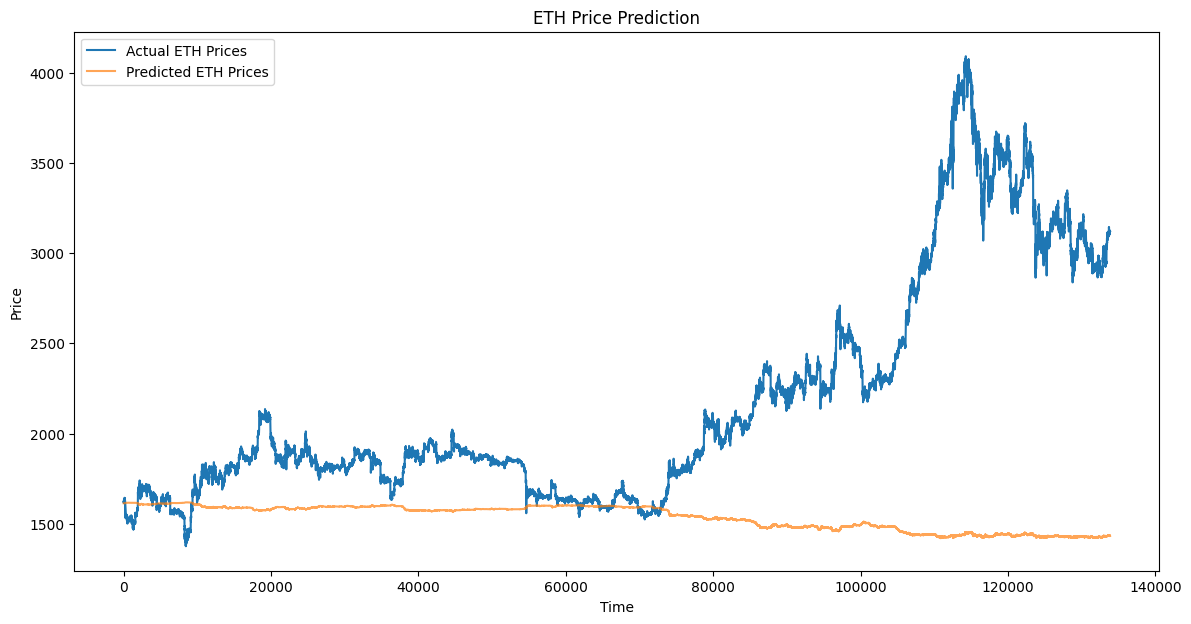

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual ETH Prices')
plt.plot(predicted_prices, label='Predicted ETH Prices', alpha=0.7)
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()